In [1]:
import hopsworks
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/213141
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# retrieve feature groups
traffic_fg = fs.get_feature_group(name='traffic_flow_data', version=1)
weather_fg = fs.get_feature_group(name='weather_data', version=1)

### Deal with traffic data

In [17]:
# Create feature view
query = traffic_fg.select_all()
# query.show(100)
traffic_fv = fs.get_or_create_feature_view(
    name='traffic_trainset',
    query=query,
    version=3,
    labels=['current_speed']
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/213141/fs/213060/fv/traffic_trainset/version/3


In [18]:
# Create training set
# yesterday = (datetime.now()-timedelta(days=1)).day
# today = datetime.now().day
traffic_fv.create_training_data()

Finished: Materializing data to Hopsworks, using ArrowFlight (1.22s) 


(1,
 b'/Projects/han760/han760_Training_Datasets/traffic_trainset_3_1/traffic_trainset_3/part-00000.parquet')

In [19]:
traffic_train = traffic_fv.get_training_data(training_dataset_version=1)

In [39]:
traffic_train = pd.concat([traffic_train[0], traffic_train[1]], axis=1)

In [41]:
# Extract day 27 and 28 as a trainset
traffic_train  = traffic_train[(traffic_train['day']==27) | (traffic_train['day']==28)]

In [54]:
traffic_train

,free_flow_speed,confidence,weekend,day,hour,minute,current_speed
353,36,1.0,False,27,0,1,36
354,36,1.0,False,27,0,3,36
355,36,1.0,False,27,0,5,36
356,36,1.0,False,27,0,7,36
357,36,1.0,False,27,0,9,36
...,...,...,...,...,...,...,...
1057,36,1.0,False,28,23,39,36
1058,36,1.0,False,28,23,44,36
1059,36,1.0,False,28,23,49,36
1060,36,1.0,False,28,23,54,36


In [78]:
# Make a segment of traffic data every 15 minutes (average with round)
traffic_train_new = pd.DataFrame(columns=['free_flow_speed', 'confidence', 'weekend', 'day', 'hour', 'minute', 'current_speed'])
for day in [27, 28]:
    for hour in range(24):
        for i in range(4):
            free_flow_speed=np.sum([traffic_train[(traffic_train['day']==day) &
                                    (traffic_train['hour']==hour) &
                                    (traffic_train['minute'].isin(range(i*15, (i+1)*15)))]['free_flow_speed']])
            confidence=np.sum([traffic_train[(traffic_train['day']==day) &
                                (traffic_train['hour']==hour) &
                                (traffic_train['minute'].isin(range(i*15, (i+1)*15)))]['confidence']])
            current_speed=np.sum([traffic_train[(traffic_train['day']==day) &
                                (traffic_train['hour']==hour) &
                                (traffic_train['minute'].isin(range(i*15, (i+1)*15)))]['current_speed']])
            count = len([traffic_train[(traffic_train['day']==day) &
                    (traffic_train['hour']==hour) &
                    (traffic_train['minute'].isin(range(i*15, (i+1)*15)))]][0])
            free_flow_speed //= count
            confidence /= count
            current_speed //= count
            weekend = False
            minute = i*15

            new_data = {'free_flow_speed': free_flow_speed,
                        'confidence': confidence,
                        'weekend': weekend,
                        'day': day,
                        'hour': hour,
                        'minute': minute,
                        'current_speed': current_speed}
            traffic_train_new.loc[len(traffic_train_new)] = new_data

traffic_train_new

,free_flow_speed,confidence,weekend,day,hour,minute,current_speed
0,36,1.0,False,27,0,0,36
1,36,1.0,False,27,0,15,36
2,36,1.0,False,27,0,30,36
3,36,1.0,False,27,0,45,36
4,36,1.0,False,27,1,0,36
...,...,...,...,...,...,...,...
187,36,1.0,False,28,22,45,36
188,36,1.0,False,28,23,0,36
189,36,1.0,False,28,23,15,36
190,36,1.0,False,28,23,30,36


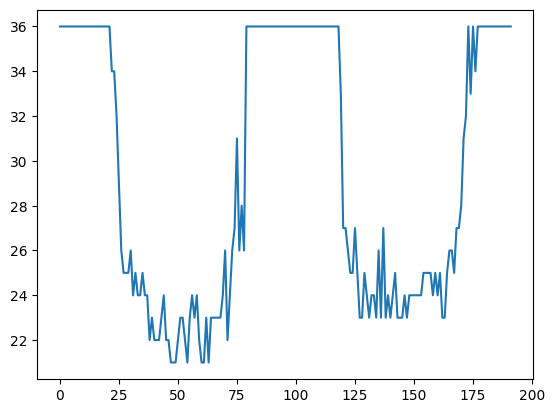

In [82]:
# from matplotlib import pyplot 
# x = traffic_train_new['current_speed']

# pyplot.plot(x)
# pyplot.show()

In [83]:
# Save the traffic trainset as a csv file
traffic_train_new.to_csv('traffic_trainset.csv', index=False)

### Deal with weather data

In [4]:
# Create feature view
query = weather_fg.select_all()
try:
    weather_fv = fs.get_feature_view(name='weather_trainset', version=1)
except:
    weather_fv = fs.get_or_create_feature_view(
        name='weather_trainset',
        query=query,
        version=1
    )

In [12]:
# Create training set
# weather_fv.create_training_data()
weather_train = weather_fv.get_training_data(training_dataset_version=1)[0]

In [13]:
# Extract day 27 and 28 as a trainset
weather_train  = weather_train[(weather_train['day']==27) | (weather_train['day']==28)]

In [14]:
weather_train = weather_train.reset_index(drop=True)

In [15]:
# Fill empty hours (use the nearest data)
for day in [27, 28]:
    for hour in range(24):
        ind = hour + 24*(day%27)
        if weather_train.loc[ind]['hour']!=hour:
            i=1
            hours_of_the_day = weather_train[weather_train['day']==day]['hour'].to_list()
            while hour-i not in hours_of_the_day and \
                hour+i not in hours_of_the_day:
                i+=1
            if hour-i in hours_of_the_day:
                new_data = weather_train[(weather_train['day']==day) & (weather_train['hour']==hour-i)]
                new_data['hour']=hour
                weather_train = pd.concat([weather_train.iloc[:ind], new_data, weather_train.iloc[ind:]]).reset_index(drop=True)
            elif hour+i in hours_of_the_day:
                new_data = weather_train[(weather_train['day']==day) & (weather_train['hour']==hour+i)]
                new_data['hour']=hour
                weather_train = pd.concat([weather_train.iloc[:ind], new_data, weather_train.iloc[ind:]]).reset_index(drop=True)

weather_train

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,day,hour,temp,wd,ws,prec1h,frsn1h,vis
0,27,0,-5.6,275,4.2,0.0,0.0,60.0
1,27,1,-5.6,275,4.2,0.0,0.0,60.0
2,27,2,-5.6,275,4.2,0.0,0.0,60.0
3,27,3,-5.3,281,4.0,0.0,0.0,58.7
4,27,4,-5.3,281,4.0,0.0,0.0,58.7
5,27,5,-3.5,287,5.1,0.0,0.0,58.9
6,27,6,-3.5,287,5.1,0.0,0.0,58.9
7,27,7,-3.5,287,5.1,0.0,0.0,58.9
8,27,8,-2.7,286,5.1,0.0,0.0,55.8
9,27,9,-2.2,285,5.7,0.0,0.0,49.8


In [16]:
# Save the weather trainset as a csv file
weather_train.to_csv('weather_trainset.csv', index=False)